## LPC Filter + Weiner Khinchin + Levinson Durbin

Librosa offers an implementation of the LPC filter calculation through the ```lpc()``` function, which provides a good base line to model the pulse coloration filters. I do believe that this is equivalent to the homonymous matlab function. 

In [2]:
# libraries here

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, spectrogram, welch
from scipy.io import loadmat, wavfile, savemat
#from scipy.linalg import solve_toeplitz
import librosa
from IPython.display import Audio

# Data and src paths
DATA_PATH = '/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/data/'
SRC_PATH = '/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/src/'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

#plt.rcdefaults()

In [3]:
# as a wise man as said, this is sub-optimal ODFT computation

def odft(x, N):
    """
    Computes the Odd Discrete Fourier Transform (ODFT) of a given signal.

    Parameters:
    x (array-like): The input signal.
    N (int): The number of samples in the DFT.

    Returns:
    array-like: The ODFT of the input signal.
    """
    f = np.arange(N) # from 0 to N-1
    dirExp = np.exp(-1j * np.pi * f / N)

    X = np.fft.fft(x*dirExp)

    #plt.plot(abs(X)) # plot the DFT magnitude

    return X

def iodft(X, N):
    """
    Performs the inverse odd discrete Fourier transform (IODFT) on the input signal.

    Parameters:
    X (array-like): The input signal in the frequency domain.
    N (int): The length of the input signal.

    Returns:
    array-like: The output signal in the time domain after applying the IODFT.
    """
    x = np.fft.ifft(X)

    f = np.arange(N) # from 0 to N-1
    x = x * np.exp(1j * np.pi * f / N)

    return x

a = np.random.normal(0, 1, 1024)
assert iodft(odft(a, 1024), 1024).all() == a.all()

Another way to calculate the reflection coefficients required for the LPC filter coefficient calculation through the levinson-durbin algorithm is to take advantage of the Weiner-Khinchin theorem.

Weiner-Khinchin states that the autocorrelation sequence is the inverse Fourier transform of the its power spectral density. So we can apply the FFT to the input signal, do a power spectral density estimation of it's frequency domain representation and do the IFFT to get the autocorrelation sequence.

Considering a input signal $x[n]$ and it's discrete fourier transform $X[k]$:

$$X[k] = \sum^{N-1}_{n=0} x[n] e^{-j\frac{2\pi}{N}kn}$$

It's power spectral density $PSD[k]$ is given by:

$$ PSD[k] = \frac{1}{N} |X[k]|^2 $$

Then we can just take the inverse DFT of the PSD to obtain the autocorrelation sequence $r[n]$.

$$r[m] = \sum^{N-1}_{k=0} PSD[k] e^{-j\frac{2\pi}{N}km}$$

The discrete case is defined by the weiner-khinchin theorem using the DFT. For our purposes, since all frames are concatenated afterwards, better results are obtained by using the ODFT. These results differ from the direct application of the autocorrelation rule, yet they work for this purpose.

In [4]:
N = 16
np.random.seed(16)
x = np.random.randn(N)

# Autocorrelation
def weinerKhinchin(x):
    n = len(x)
    x_k = odft(x, N)
    psd = (np.abs(x_k) ** 2) 
    r = iodft(psd, N).real
    return r

r1 = weinerKhinchin(x)
print("r1: ", r1)

r2 = np.correlate(x, x, mode='full')
print("r2: ", r2[int(len(r2)/2):])

r1:  [ 1.25150327e+01  4.17887416e-01  4.15044927e+00  8.52823483e-01
  3.12691333e+00  1.29866721e-01  2.12799813e+00 -3.08407729e-01
  5.43852429e-32  3.08407729e-01 -2.12799813e+00 -1.29866721e-01
 -3.12691333e+00 -8.52823483e-01 -4.15044927e+00 -4.17887416e-01]
r2:  [12.51503274  0.65900218  1.22627109  0.12623147  4.89956078 -0.27156749
  0.96096697  0.30635689  3.11291948  0.61476461 -1.16703115 -0.40143421
  1.77264744 -0.72659201 -2.92417818  0.24111476]


### Levinson-Durbin algorithm

The levinson-durbin algorithm is a method widely used in signal processing application to solve the autoregressive linear prediction problem. Considering the autocorrelation $r[n]$ sequence obtained from data points $x[n]$:

1. Initialize the algorithm by setting the first reflection coefficient, denoted as $k[0]$, to the ratio of the first element of $r$ to the first element of the prediction error $e[0]$. This prediction error is initially set to $r[0]$

2. Calculate the first autoregressive (AR) coefficient, denoted as $a[0]$, using the first reflection coefficient: $a[0] = k[0]$

3. Iterate through the remaining coefficients, from m to N-1 where N is the desired filter order:
    1. Calculate the $m$-th reflection coefficient, $k[m]$, using the previous reflection coefficients and the prediction error:

    $$k[m] = (r[m] - \sum_{i=0}^{m-1}(a[i] * r[m-i])) / e[m-1]$$
    
    2. Update the prediction error $e[m]$ using the previous prediction error and the $m$-th reflection coefficient: 
    
    $$e[m] = e[m-1] (1-k[m]^2)$$

    3. Calculate the $m$-th AR coefficient, denoted as $a[m]$ using the previous AR coefficients and the $m$-th reflection coefficient:

    $$a[m] = a[m-1] - k[m] * a[m-1]$$

4. The resulting AR coefficients $a$ represent the best linear prediction model for the input sequence $x$

In [5]:
import numpy as np

def levinson(r, N):
    k = np.zeros(N+1) # Reflection coefficients
    A = np.zeros(N+1) # Prediction filter coefficients
    A[0] = 1.0
    E = np.real(r[0]) # Prediction error

    # Levinson-Durbin recursion
    for i in range(1, N+1):
        lambda_ = -np.dot(r[1:i+1], A[i-1::-1]) / E
        A[1:i+1] += lambda_ * A[i-1::-1]
        E *= (1.0 - lambda_ * lambda_)
        k[i] = -lambda_  # Reflection coefficient is the negation of lambda_
    
    return A, E, k[1:]

x = np.array([1.0, 0.7, 0, 0.5, 1.0, 0.5, 0.0, 0.5, 1.0])
N = 6

A, E, k = levinson(x, N)

print("Filter coefficients:", A)
print("Prediction error:", E)
print("Reflection coefficients:", k)

# Compare with matlab levinson
result = np.array([1.000000000000000, -0.158730158730140, -0.603174603174617, -0.158730158730125, -0.587301587301598, -0.317460317460331, 0.984126984126981])

assert np.allclose(A, result)

Filter coefficients: [ 1.         -0.15873016 -0.6031746  -0.15873016 -0.58730159 -0.31746032
  0.98412698]
Prediction error: 0.06349206349207592
Reflection coefficients: [ 0.7        -0.96078431 29.9         0.9988578   5.12       -0.98412698]


There is already an implementation of the levinson-durbin algorithm in the CMSIS ARM library:

https://www.keil.com/pack/doc/CMSIS/DSP/html/group__LD.html#ga2ea8733ba29641f2f081251da672dabf

Doubt this is hardware accelerated, it is probably faster than my implementation

In [6]:
x = np.array([1.0, 0.7, 0, 0.5, 1.0, 0.5, 0.0, 0.5, 1.0])
N = 6

a1 = levinson(x, N)[0]

print("a1 (levinson):", a1)

# Compare with matlab levinson
result = np.array([1.000000000000000, -0.158730158730140, -0.603174603174617, -0.158730158730125, -0.587301587301598, -0.317460317460331, 0.984126984126981])

assert np.allclose(a1, result)

a1 (levinson): [ 1.         -0.15873016 -0.6031746  -0.15873016 -0.58730159 -0.31746032
  0.98412698]


### IIR filtering Direct Form II

The LPC filter can be implemented using the Direct Form II IIR filter structure. This structure is given by the following difference equation:

$$y[n] = b[0] * x[n] + w[n-1]$$

Where $b[0]$ and $b[1]$ are the filter coefficients and $w[n]$ is the internal state of the filter. The LPC filter can be implemented using the Direct Form II IIR filter structure.

Below is a python code that validates the implementation of the IIR filter that is going to be implemented in python...

In [7]:
def iirFilter(input, b0, a):
    """
    Applies an IIR filter to the input signal.

    Parameters:
    input (array-like): The input signal.
    b0 (float): The feedforward coefficient.
    a (array-like): The feedback coefficients.

    Returns:
    array-like: The output signal after applying the IIR filter.
    """
    coeffLen = len(a)
    inLen = len(input)
    
    output = np.zeros(inLen)
    w = np.zeros(coeffLen) # delay line

    for i in range(inLen):
        w[0] = input[i]
        
        for j in range(1, coeffLen):
            w[0] -= a[j] * w[j]

        output[i] = b0 * w[0]

        for j in range(coeffLen - 1, 0, -1): # shift delay line
            w[j] = w[j - 1]

    return output

b0 = 1
a = np.array([1, 0.33, 0.33, 0.33])
input = np.random.randn(1024)

output = iirFilter(input, b0, a)    # literally me
reference = lfilter([b0], a, input) # scipy 

#print(output[:10])
#print(reference[:10])

assert np.allclose(output, reference) # golden

# compare lfilter to matlab's filter
x = np.array([1, 2, -2, 1])
a = np.array([1, 3, 3, 3])
y = np.array([1, -1, -2, 7]) # result from matlab's lfilter
y_hat = lfilter([1.0], a, x)

assert np.allclose(y_hat, y)

# Filter testing

Let's first utilize a simple vowel model for every frame of the file. For this we can use one mono recording of a single vowel... These first samples were recorded using the iPhone XR 

/tmp/ipykernel_7016/3597902959.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio_data = wavfile.read(vowelSoundFile)


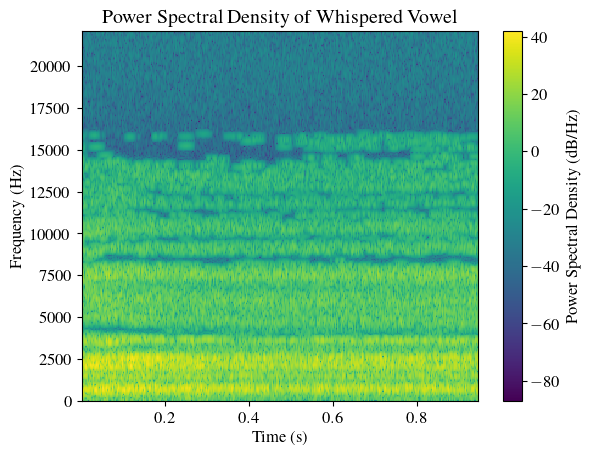

In [8]:
from IPython.display import Audio
from scipy import signal
import numpy as np
from librosa import resample

# Load the sound file
DATA_PATH = '/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/data/'
vowelSoundFile = DATA_PATH + 'vowelModels/Vowel_E.wav' # EEEEEEEEEEE

# Read the audio data
fs, audio_data = wavfile.read(vowelSoundFile)

# Trim the audio
audio_data = audio_data[int(0.15*fs):int(1.1*fs)]

# Calculate the power spectral density
frequencies, times, psd = signal.spectrogram(audio_data, fs, nperseg=256, nfft=1024, noverlap=128, window='hann')

# Plot the power spectral density
plt.pcolormesh(times, frequencies, 10 * np.log10(psd))
#plt.ylim(0, 5000)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power Spectral Density (dB/Hz)')
plt.title('Power Spectral Density of Whispered Vowel ')
plt.show()

FS = 22500
audio_data_2 = resample(audio_data.astype(np.float32), orig_sr=fs, target_sr=FS)

Audio(audio_data_2, rate=FS)

### LF pulse generation

Directly from the LF model definition (not subtitle for fourier analysis and real time pulse generation)

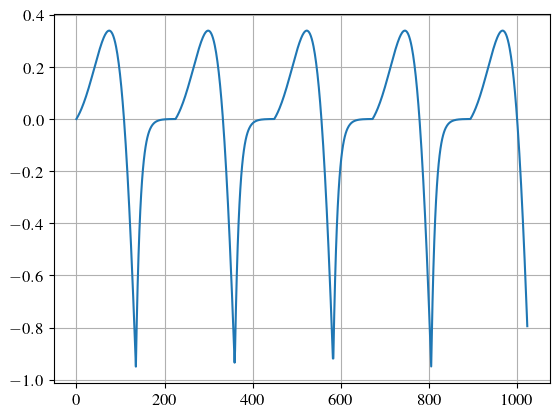

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# direct translation from the voicebox matlab code
def v_glotlf(d=0, t=None, p=None):
    if p is None:
        p = np.array([0.6, 0.1, 0.2])
    elif len(p) < 3:
        default_p = np.array([0.6, 0.1, 0.2])
        p = np.concatenate([p, default_p[len(p):]])

    if t is None:
        tt = np.linspace(0, 0.99, 100)
    else:
        tt = t - np.floor(t)  # only interested in the fractional part of t

    te = p[0]
    mtc = te - 1
    e0 = 1
    wa = np.pi / (te * (1 - p[2]))
    a = -np.log(-p[1] * np.sin(wa * te)) / te
    inta = e0 * ((wa / np.tan(wa * te) - a) / p[1] + wa) / (a**2 + wa**2)

    rb0 = p[1] * inta
    rb = rb0
    for _ in range(4):
        kk = 1 - np.exp(mtc / rb)
        err = rb + mtc * (1 / kk - 1) - rb0
        derr = 1 - (1 - kk) * (mtc / rb / kk)**2
        rb = rb - err / derr

    e1 = 1 / (p[1] * (1 - np.exp(mtc / rb)))
    ta = tt < te
    tb = ~ta

    if d == 0:
        u = np.zeros_like(tt)
        u[ta] = e0 * (np.exp(a * tt[ta]) * (a * np.sin(wa * tt[ta]) - wa * np.cos(wa * tt[ta])) + wa) / (a**2 + wa**2)
        u[tb] = e1 * (np.exp(mtc / rb) * (tt[tb] - 1 - rb) + np.exp((te - tt[tb]) / rb) * rb)
    elif d == 1:
        u = np.zeros_like(tt)
        u[ta] = e0 * np.exp(a * tt[ta]) * np.sin(wa * tt[ta])
        u[tb] = e1 * (np.exp(mtc / rb) - np.exp((te - tt[tb]) / rb))
    elif d == 2:
        u = np.zeros_like(tt)
        u[ta] = e0 * np.exp(a * tt[ta]) * (a * np.sin(wa * tt[ta]) + wa * np.cos(wa * tt[ta]))
        u[tb] = e1 * np.exp((te - tt[tb]) / rb) / rb
    else:
        raise ValueError('Derivative must be 0, 1, or 2')

    return u

# helper function for generating single lfPulses
def lfPulse(F0, Fs, gain = 0.95):
    if np.isscalar(F0): # simple, just generate one wave pulse
        t = np.arange(0, 1/F0, 1/Fs)
        u = v_glotlf(1, t*F0)  # compute the waveform using default parameters
    else: # generate multiple pulses and concatenate
        pos = 0
        pulse = np.array([])
        
        while pos < len(F0):
            f0 = F0[pos]
            t = np.arange(0, 1/f0, 1/Fs)
            pulse = np.concatenate([pulse, v_glotlf(1, t*f0)])
            pos += len(t)

        u = pulse

    # Normalize the waveform
    u = gain * u / np.max(np.abs(u))

    return u

F0 = 100; FS = 22500
F0 = np.linspace(100, 200, FS*2)

audio = lfPulse(F0, FS)
plt.plot(audio[:1024])
plt.grid(True)

Audio(lfPulse(F0, FS), rate=FS)

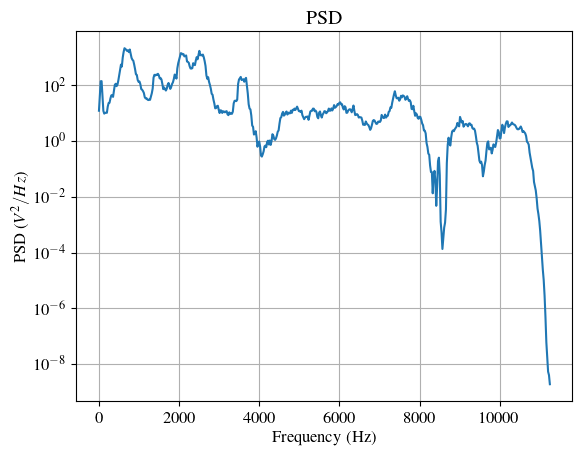

In [10]:
nLPC = 20 
N = 512
F0 = 110.0

# Calculate the power spectral density
f, Pxx_den = signal.welch(audio_data_2, FS, nperseg=1024)

plt.semilogy(f, Pxx_den)
#plt.loglog(f, Pxx_den)
plt.title('PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'PSD ($V^2/Hz$)')
plt.grid(True)
plt.show()

# Calculate the LPC coefficients
PSD = Pxx_den[:N] # ditch the last freq. bin nyquist
r = iodft(PSD, N).real
a = levinson(r, nLPC)[0]

# Synthesize a 5 second
pulse = lfPulse(F0, FS, 5*FS)
pulse = np.concatenate((pulse, np.zeros(200)))
filtered_pulse = signal.lfilter([1], a, pulse)

#normalize the sound
filtered_pulse = filtered_pulse / np.max(np.abs(filtered_pulse)) * 32767

# Play the synthesized sound
Audio(filtered_pulse, rate=FS)

## Spectral envelope templates

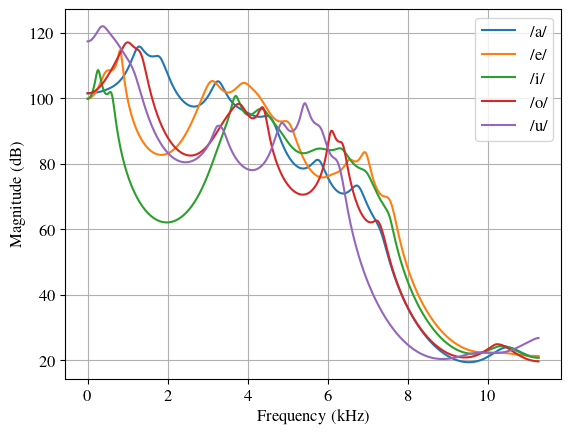

In [11]:
DATA_PATH = '/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/data/'
FS = 22500; N = 1024; N2 = N//2

# load the vowel templates
# keep in mind that the templates are in dB
mat = loadmat(DATA_PATH + 'templatesAJF/sofia_a_hlpc.mat')
vowelA = mat['sumhLPC'][0]
mat = loadmat(DATA_PATH + 'templatesAJF/sofia_e_hlpc.mat')
vowelE = mat['sumhLPC'][0]
mat = loadmat(DATA_PATH + 'templatesAJF/sofia_i_hlpc.mat')
vowelI = mat['sumhLPC'][0]
mat = loadmat(DATA_PATH + 'templatesAJF/sofia_o_hlpc.mat')
vowelO = mat['sumhLPC'][0]
mat = loadmat(DATA_PATH + 'templatesAJF/sofia_u_hlpc.mat')
vowelU = mat['sumhLPC'][0]

vowels = {'a': vowelA, 'e': vowelE, 'i': vowelI, 'o': vowelO, 'u': vowelU}

fig, ax = plt.subplots(1)
#ax.set_title('Vowel Templates')
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel("Magnitude (dB)")
for key, value in vowels.items():
    ax.plot(np.linspace(0, FS/2, N2)/1e3, value, label='/'+key+'/')

ax.legend()
ax.grid(True)

#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter5/vowelsTemplates.pdf', format='pdf', dpi = 300, bbox_inches='tight')

A(z): [  1.          -3.45537473   8.19917641 -14.87588256  21.59781453
 -26.86119314  27.52080098 -23.47068147  15.22612697  -5.09124528
  -3.10243573   8.03144452  -7.87112994   4.36545      0.61467638
  -5.14510462   7.29963549  -7.5188986    5.90106695  -3.82256547
   2.00392343  -0.74992837   0.22300826]


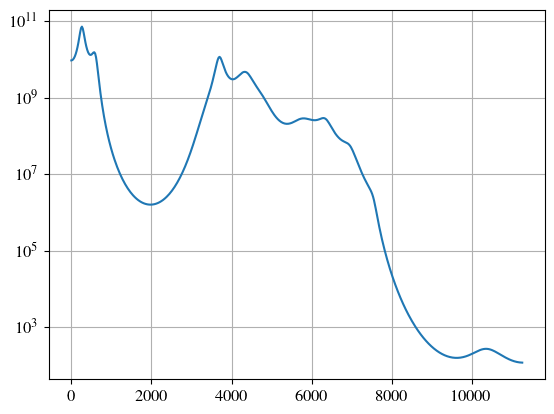

In [12]:
# Generate vowels without tilt compensation
F0 = 250
# generate a 4 sec lf-model gfd pulse
pulse = lfPulse(np.ones(2*FS)*F0, FS, 1*FS)

# select vowel templates and linearize the magnitude
vowelModel = vowelI
vowelModel = 10**(vowelModel/10.0)
vowelModel = np.concatenate((vowelModel, vowelModel[::-1])) # extremely important line of code

plt.semilogy(np.linspace(0, FS/2, 512), vowelModel[:512])
plt.grid(True)

N = len(vowelModel); N2 = N // 2
# Calculate the LPC coefficients
# First the autocorrelation sequence r
r = iodft(vowelModel, N).real
a = levinson(r[:N2], 22)[0]
print("A(z):", a)

pulse = np.concatenate((pulse, np.zeros(1000)))
filteredPulse = lfilter([1], a, pulse)

#output the file 
#wavfile.write(filename=DATA_PATH + 'outputU.wav', rate=FS, data=np.int16(filteredPulse / np.max(np.abs(filteredPulse)) * 32767))
Audio(filteredPulse, rate=FS)

### Spectral Tilt Compensation

It is wrong to take this PSD template directly and generate a filter from it, has when passed through the LPC/IIR filter the output signal has a PSD that reflects the multiplicative effects of the glottal excitation. We can show this by plotting the PSD of the glottal pulse in regards to the normalized frequency $f/F_0$.



m1_IP:  -5.968431149938542
b1_IP:  -1.4125851992485496e-16
m2_IP:  -32.9522014311249
b2_IP:  8.122924250743393


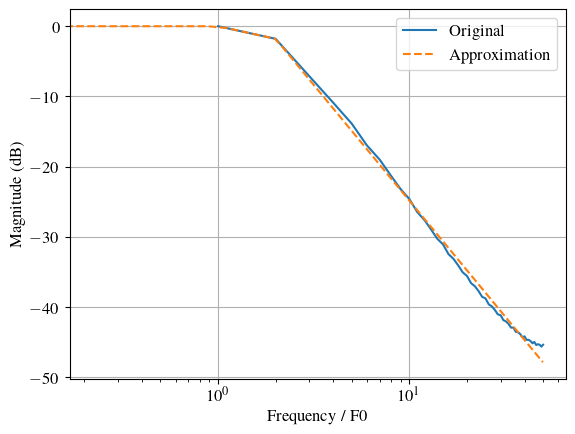

In [13]:
# Load delay coefficients and magnitudes from matlab files
mat = loadmat('LFNRD.mat')
LFnrd = mat["LFNRD"][0]
mat = loadmat('LFmag.mat')
LFmag = mat["LFmag"][0]

# NRD linear model + adjustments
# linear model of the first 20 nrd 
P = np.polyfit(np.arange(1,19), LFnrd[1:19], 1)
tmp_modelo = np.polyval(P, np.arange(1,120)) # extrapolate to 120
# shift the model to match the 20th value
shift_NRD = LFnrd[19] - tmp_modelo[19]
tmp_modelo = tmp_modelo + shift_NRD
tmp_modelo[:18] = LFnrd[:18] 

LFmag = LFmag - LFmag[0]
eixox = np.arange(1, 121)
logeixox = np.log10(eixox)

P2 = np.polyfit(logeixox[1:48], LFmag[1:48], 1)
modelo2 = np.polyval(P2, logeixox[:120])
offset = LFmag[1] - np.polyval(P2, logeixox[1])
modelo2 = modelo2 + offset
modelo2[:2] = LFmag[:2]

P1 = np.polyfit(logeixox[:2], LFmag[:2], 1)
modelo_IP = np.polyval(P1, logeixox[:2])

offset = np.polyval(P1, logeixox[1]) - np.polyval(P2, logeixox[1])
P2[1] = P2[1] + offset
modelo1 = np.polyval(P2, logeixox[1:48])

# three rules exist for compensating the magnitude curve
#      f/F0 < 1         -> G = 1
#      1 <= f/F0 < 2    -> G = m1*(f/F0) + b1
#      f/F0 >= 2        -> G = m2*(f/F0) + b2

m1_IP = P1[0]; b1_IP = P1[1]
m2_IP = P2[0]; b2_IP = P2[1]

# we can then define a function that calculates the gain
# that should be applied to the magnitude curve at a specific frequency

print("m1_IP: ", m1_IP)
print("b1_IP: ", b1_IP)
print("m2_IP: ", m2_IP)
print("b2_IP: ", b2_IP)

def tiltGain(F0, Fs, N):
    T0 = Fs/F0
    N2 = N//2

    gain = np.zeros(N2)

    for kk in range(0,N2):
        ratio = kk * (Fs/F0) / N
        if ratio < 1.0:
            gain[kk] = 1.0
        elif ratio < 2.0:
            gain[kk] = (ratio**(m1_IP/20)) * 10**(b1_IP/20)
        else:
            gain[kk] = (ratio**(m2_IP/20)) * 10**(b2_IP/20)

    return gain

F0 = 100; Fs = 22500; N = 1024; N2 = N//2
ratio = np.arange(N2) * (FS/F0) / N 
idx = (ratio <= 50.0)

fig, ax = plt.subplots(1)
#ax.set_title('Tilt Gain')
ax.semilogx(np.arange(1, len(LFmag)+1), LFmag[:], label = 'Original')
ax.semilogx(ratio[idx], 20*np.log10(tiltGain(F0, FS, N)[idx]), linestyle = '--', label = 'Approximation')
ax.set_ylabel('Magnitude (dB)')
ax.set_xlabel('Frequency / F0')
ax.legend()
ax.grid(True)

# export svg for the report
#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter5/glottalPulseTiltGain.pdf', format='pdf', dpi = 300)

Here we should explain why it is that the tilt compensation varies along with the fundamental frequency of the pulse...

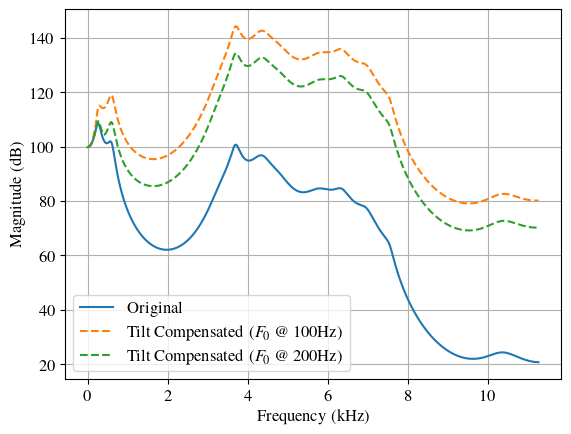

In [14]:
# select vowel templates and linearize the magnitude
vowel = vowelI
vowelModel = 10**(vowel/10.0)
vowelModel = np.concatenate((vowelModel, vowelModel[::-1])) # extremely important line of code 

fig, ax = plt.subplots(1)

#ax.semilogy(np.linspace(0, FS/2, 512), vowelModel[:512])
ax.grid(True)

ax.plot(np.linspace(0, FS/2, 512)/1e3, vowel[:512], label = 'Original')

# create tilt compensated model
tiltCompensatedModel = vowel - 20 * np.log10(tiltGain(100, FS, N))
ax.plot(np.linspace(0, FS/2, 512)/1e3, tiltCompensatedModel, label = r'Tilt Compensated ($F_0$ @ $100$Hz)', linestyle='--')
tiltCompensatedModel = vowel - 20 * np.log10(tiltGain(200, FS, N))
ax.plot(np.linspace(0, FS/2, 512)/1e3, tiltCompensatedModel, label = r'Tilt Compensated ($F_0$ @ $200$Hz)', linestyle='--')

#ax.set_title("PSD Vowel /i/")
ax.set_xlabel("Frequency (kHz)")
ax.set_ylabel("Magnitude (dB)")
ax.legend()

# export svg for the report
#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter5/vowelTiltCompensation.pdf', format='pdf', dpi = 300)

Now let us generate a new vowel model to be synthesized using the tilt compensation function...

Also for a more natural sounding synthetic vowel, we'll use the f0 contour that we've generated previously

In [15]:
# Create the contour
buffer_size = 512; Fs = 22500
length = 70 # length in frames

Ts = 1/Fs
F0 = 250
alpha = 0.8  # Arbitrary chosen
beta = 1  # Arbitrary chosen
gamma = 5 * 2 * np.pi / 25  # 4 full sine wave cycle every 25 frames
theta = 0.1

# Define the function for the F0 contour
def F0_contour(x, F0, alpha, beta, gamma, theta):
    x = x*buffer_size/length # use with the time setting only

    return F0 * (1 - alpha * x) * np.exp(-beta * x) * np.sin(gamma * x) - theta*x + F0

# Generate x values corresponding to frame numbers
time = np.arange(0, length*buffer_size*Ts, Ts)
#frames = np.arange(0, 25*buffer_size*Ts, Ts)

# Calculate the F0 contour
contour = F0_contour(time, F0, alpha, beta, gamma, theta)
contour = (contour - contour[-1])*0.2 + F0 # 

# extend the f0 contour with the last frequency value
contour = np.concatenate([contour, np.full(2 * Fs, contour[-1])])

# add a vibrato effect
vibrato = 4 # Hz
t = np.arange(0, len(contour)/Fs, 1/Fs)
modulation = 1 * np.sin(2 * np.pi * vibrato * t)
contour = contour + modulation

In [16]:
""" F0 = 258 # 258 Hz fits evenly (6 times) into 22500 Hz @ 512 samples 
vowel = vowelU
tilt = 20 * np.log10(tiltGain(F0, FS, N))
model = vowel - tilt
model = 10**(model/20.0)
model = np.concatenate((model, model[::-1])) # extremely important line of code

# Calculate the LPC coefficients
# First the autocorrelation sequence r
r = iodft(model, N).real

[a, g, r] = levinson(r[:N2], 22)
#print("A(z):", a)
b0 = np.sqrt(g)
#b0 = 1

#pulse = lfPulse(contour, FS, 1*FS) # 1 sec pulse
pulse = lfPulse(F0 * np.ones(2*FS), Fs, gain=1)
#wavfile.write(filename = DATA_PATH + 'vowelFromTemplate/tiltCompensation/outputPulses.wav', rate=FS, data=np.int16(pulse / np.max(np.abs(pulse)) * 32767))
#pulse = np.concatenate((pulse, np.zeros(1000)))
filteredPulse = lfilter(b0, a, pulse)

plt.plot(np.arange(512)/Fs, filteredPulse[:512])
plt.grid()
#output the file
#wavfile.write(filename = DATA_PATH + 'vowelFromTemplate/tiltCompensation/outputU.wav', rate=FS, data=np.int16(filteredPulse / np.max(np.abs(filteredPulse)) * 32767))
Audio(filteredPulse, rate=FS) """

' F0 = 258 # 258 Hz fits evenly (6 times) into 22500 Hz @ 512 samples \nvowel = vowelU\ntilt = 20 * np.log10(tiltGain(F0, FS, N))\nmodel = vowel - tilt\nmodel = 10**(model/20.0)\nmodel = np.concatenate((model, model[::-1])) # extremely important line of code\n\n# Calculate the LPC coefficients\n# First the autocorrelation sequence r\nr = iodft(model, N).real\n\n[a, g, r] = levinson(r[:N2], 22)\n#print("A(z):", a)\nb0 = np.sqrt(g)\n#b0 = 1\n\n#pulse = lfPulse(contour, FS, 1*FS) # 1 sec pulse\npulse = lfPulse(F0 * np.ones(2*FS), Fs, gain=1)\n#wavfile.write(filename = DATA_PATH + \'vowelFromTemplate/tiltCompensation/outputPulses.wav\', rate=FS, data=np.int16(pulse / np.max(np.abs(pulse)) * 32767))\n#pulse = np.concatenate((pulse, np.zeros(1000)))\nfilteredPulse = lfilter(b0, a, pulse)\n\nplt.plot(np.arange(512)/Fs, filteredPulse[:512])\nplt.grid()\n#output the file\n#wavfile.write(filename = DATA_PATH + \'vowelFromTemplate/tiltCompensation/outputU.wav\', rate=FS, data=np.int16(filteredPul

AJF_14ago2023.m translated to python

**TODO**: figure out why the plot on the lf spectral tilt isn't matching to the approximated value

/tmp/ipykernel_7016/959599711.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio_in = wavfile.read(SRC_PATH + "other/sofiaWav/" + filename)


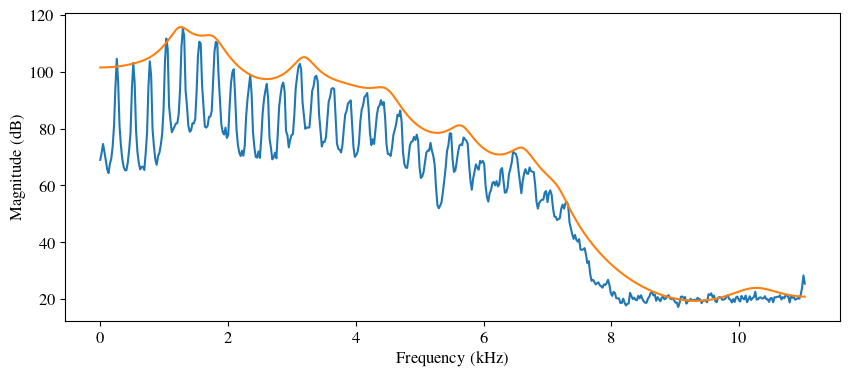

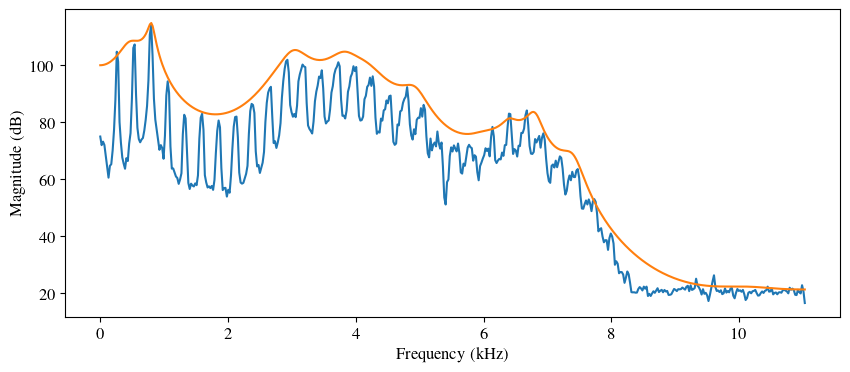

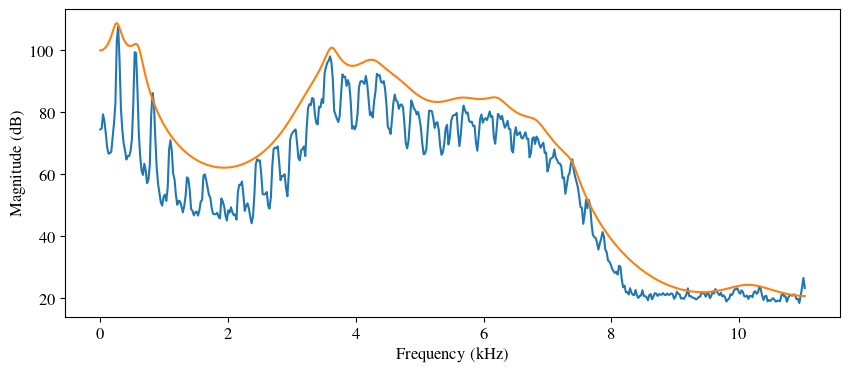

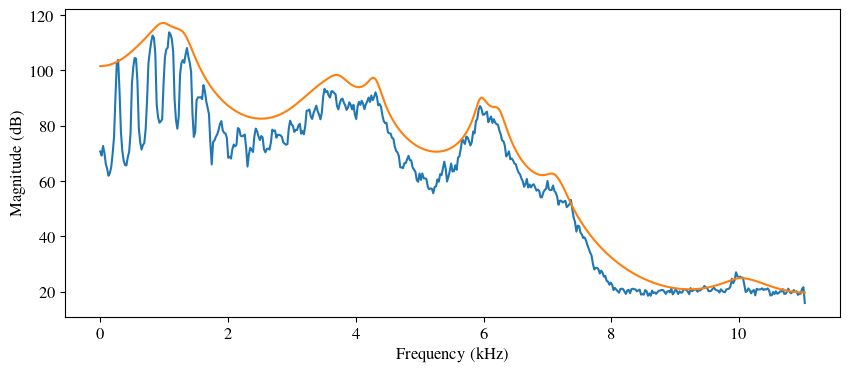

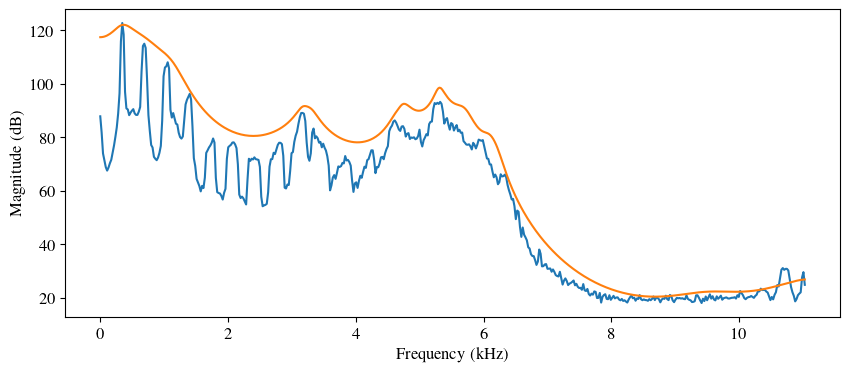

In [17]:
# PASSO 1 - fazendo o pwelch de cada um dos WAV de vogais da Sofia, comparamos graficamente com os respetivos modelos PSD (os que já enviei em .dat) para confirmar que estão alinhados

FS = 22050; N = 1024; N2 = N//2
hsin = np.sin(np.pi*(0.5 + np.arange(N))/N) # sine window

for key, value in vowels.items():
    filename = "sofia_" + key + ".wav"
    vowel = value
    #vowel -= vowel[0] # normalize to 0 dB

    fs, audio_in = wavfile.read(SRC_PATH + "other/sofiaWav/" + filename)
    audio_in = audio_in * 32768 / 512 # adjust gain
    f, audioPSD = welch(audio_in, fs=FS, window=hsin, nfft=N) # pwelch

    # convert to log scale and normalize
    audioPSD = 10*np.log10(2*N*audioPSD) - 1
    
    fig, ax = plt.subplots(figsize=(10, 4))
    #plt.plot(f/1e3, audioPSD, label= filename + " (welch)")
    ax.plot(f/1e3, audioPSD, label= "Original")
    ax.plot(np.linspace(0, FS/2, N2)/1e3, vowel, label="Spectral Envelope")
    #ax.text(1.24, 117, r"$F_1$")
    #ax.text(1.7, 114, r"$F_2$")
    #ax.text(3.15, 107, r"$F_3$")
    #ax.text(4.43, 97, r"$F_4$")
    #ax.set_xlim((0, 6))
    #ax.set_ylim(66, 125)
    #plt.legend()
    #plt.grid()
    ax.set_xlabel("Frequency (kHz)")
    ax.set_ylabel("Magnitude (dB)")
    #plt.title("Vowel template vs Audio PSD /" + key + "/")

    #plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter2/formants.pdf', format='pdf', dpi = 300, bbox_inches='tight')
    #break # comment this

Text(0, 0.5, 'Magnitude (dB)')

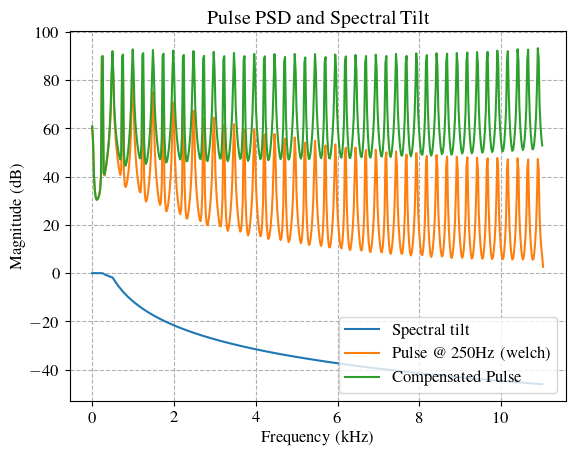

In [18]:
# PASSO 2. fazemos o pwelch do sinal WAV dos impulsos glóticos (usando F0 mais parecido com o original inferido dos WAS das gravações originais), representamos graficamente, e multiplicamos pela compensação tilt, que também representamos graficamente de forma sobreposta, assim como o resultado do produto (que tem de dar aproximadamente "flat")

F0 = 250
pulse = lfPulse(F0*np.ones(FS*2), FS, 1*FS)

f, pulsePSD = welch(pulse, fs=FS, window=hsin, nfft=N) # pwelch
pulsePSD = 10*np.log10(2*N*pulsePSD)
tilt = 20*np.log10(tiltGain(F0, FS, N))
compensatedPSD = pulsePSD[:N2] - tilt

plt.figure()
plt.plot(f[:N2]/1e3, tilt, label="Spectral tilt")
plt.plot(f/1e3, pulsePSD, label="Pulse @ 250Hz (welch)")
plt.plot(f[:N2]/1e3, compensatedPSD, label="Compensated Pulse")
plt.title('Pulse PSD and Spectral Tilt')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.xlabel("Frequency (kHz)")
plt.ylabel("Magnitude (dB)")

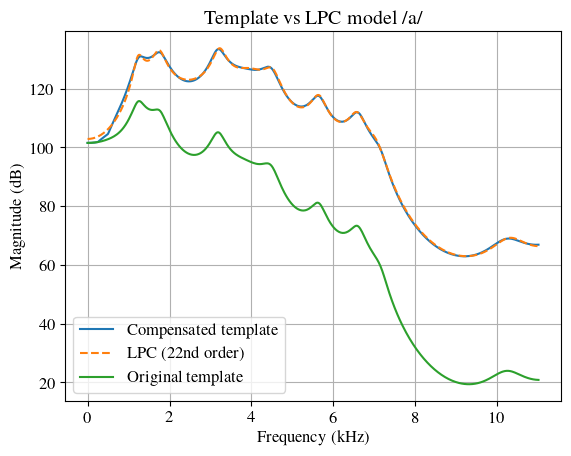

In [19]:
Nlpc = 22

# PASSO 3. para uma dada vogal, representamos a PSD já compensada do tilt e sobrepomos no gráfico a representação da magnitude da resposta em frequência do filtro IIR (que deve dar muito alinhada)

for key, value in vowels.items():
    tilt = 20 * np.log10(tiltGain(F0, FS, N))
    vowel = vowelA
    compensated = vowel - tilt
    model = compensated
    model = 10**(model/10.0)
    model = np.concatenate((model, model[::-1]))

    # write vowel model to file

    psd = (iodft(model, N).real)
    [a, g, e] = levinson(psd, Nlpc)

    b = np.sqrt(g)
    w, h = signal.freqz(b, a, N2)
    h_psd = 10*np.log10(np.abs(h)**2)

    savemat(DATA_PATH + "LPC_" + key + ".mat", {'a': a, 'b0': b, 'Nlpc': Nlpc})

    plt.figure()
    plt.plot(w/np.pi * FS/2/1e3, compensated, label="Compensated template")
    plt.plot(w/np.pi * FS/2/1e3, h_psd, label = "LPC (" + str(Nlpc)+ "nd order)", linestyle='--')
    plt.plot(w/np.pi * FS/2/1e3, vowel, label="Original template")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("Template vs LPC model /" + key + "/")
    break

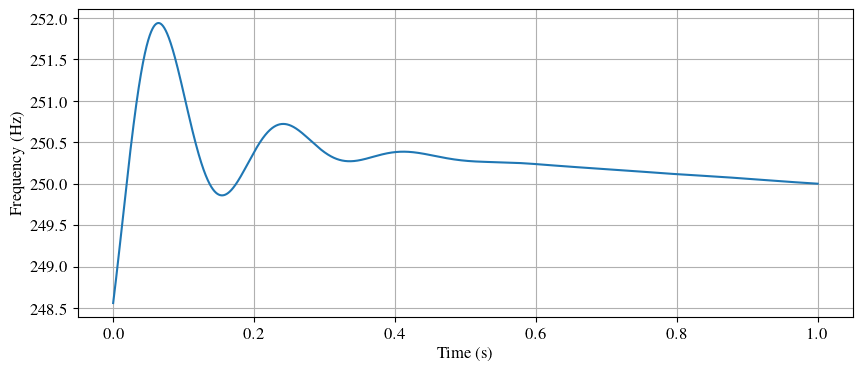

In [20]:
buffer_size = 512; Fs = 22500
length = Fs/buffer_size # length in frames (here set to be 1 second)

Ts = 1/Fs
F0 = 250
alpha = 0.13  # Arbitrary chosen
beta = 0.6  # Arbitrary chosen
gamma = 12 * 2 * np.pi / 25  # 4 full sine wave cycle every 25 frames
theta = 5
phi = 0.01

# Define the function for the F0 contour
def F0_contour(x, F0, alpha, beta, gamma, theta):
    x = x*buffer_size/length # use with the time setting only

    contour = F0 * (1 - alpha * x) * np.exp(-beta * x) * np.sin(gamma * x - 0.3*np.pi) - theta*x + F0
    contour = (contour - contour[-1]) * phi + F0

    return contour

# Generate x values corresponding to frame numbers
time = np.arange(0, length*buffer_size*Ts, Ts)

# Calculate the F0 contour
contour = F0_contour(time, F0, alpha, beta, gamma, theta)

# extend the f0 contour with the last frequency value
#contour = np.concatenate([np.full(int(0.2 * Fs), contour[0]), contour])

# add a vibrato effect
vibrato = 3 # Hz
t = np.arange(0, len(contour)/Fs, 1/Fs)
#modulation = 0.3 * np.sin(2 * np.pi * vibrato * t) # * 1/(1+np.exp(-5*t+5))
#contour = contour + modulation

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 4)
ax.plot(t, contour)
#plt.title('F0 Contour')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.grid(True)

#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter4/f0Contour.pdf', format='pdf', dpi = 300)

In [21]:
# PASSO 3.5 generate vowels from the PSD

for key, value in vowels.items():
    # generate glottal pulse
    #pulse = lfPulse(contour, FS) # follows contour
    pulse = lfPulse(F0*np.ones(FS), FS)
    t = np.arange(0, len(pulse)/Fs, 1/Fs)
    pulse = v_glotlf(1, t*F0)

    """ # plot pulse spectrogram
    f, t, Sxx = spectrogram(pulse, fs=FS, nfft=1024, window='hann')
    plt.figure()
    plt.pcolormesh(t, f[:128], 10*np.log10(Sxx[:128]))
    plt.twinx()
    plt.plot(np.linspace(0, t[-1], len(contour)), contour, color='r') """

    # select vowel templates and linearize the magnitude
    vowel = value
    tilt = 20 * np.log10(tiltGain(F0, FS, N))
    model = vowel - tilt
    model = 10**(model/10.0)
    model = np.concatenate((model, model[::-1])) # extremely important line of code

    # Calculate the LPC coefficients
    # First the autocorrelation sequence r
    psd = iodft(model, N).real

    [a, g, r] = levinson(psd, 22)
    b0 = np.sqrt(g)

    #savemat(DATA_PATH + 'vowelFromTemplate/tiltCompensation/LPC_' + key + '.mat', {'a': a, 'b0': b0, 'Nlpc': Nlpc})

    print("a: ", a)
    print("b0: ", b0)

    # filter the pulse
    filteredPulse = lfilter(100, a, pulse)

    # add fade-in and out to the vowel
    fadeLen = int(0.02*FS) # 20 ms of fadein and fadeout
    filteredPulse[:fadeLen]  *= np.linspace(0, 1, fadeLen)
    filteredPulse[-fadeLen:] *= np.linspace(1, 0, fadeLen)

    Audio(filteredPulse, rate=FS)

    #output the file
    wavfile.write(filename = DATA_PATH + 'vowelFromTemplate/constantF0/output_'+key+'.wav', rate=FS, data=np.int16(filteredPulse / np.max(np.abs(filteredPulse)) * 32767))

Audio(DATA_PATH + 'vowelFromTemplate/tiltCompensation/output_e.wav', rate=FS)

a:  [  1.          -3.56018445   7.97021317 -12.71042867  16.03850806
 -15.68614206  11.31567925  -3.71767768  -3.93117113   9.17894871
  -9.93343347   6.97790725  -1.82948168  -2.76171435   5.46348437
  -5.65824728   4.37828272  -2.45242487   0.98733188  -0.15435453
  -0.02705114   0.01881448   0.01900302]
b0:  129305.29586579849
a:  [  1.          -2.71639269   6.0736661   -9.49911092  12.92384055
 -14.47663591  13.57728826 -10.22978819   5.08853238  -0.13748179
  -3.60530918   5.18717651  -4.48090483   2.70685829  -0.24151217
  -1.15907938   1.94882946  -1.62597579   1.07639098  -0.42738982
   0.02911339   0.06872343  -0.06020901]
b0:  146370.42988199636
a:  [ 1.         -1.6695269   4.20343093 -5.33286547  7.03375982 -6.98051858
  4.93812861 -3.34751074 -0.71953273  1.71451152 -3.29143571  2.52279243
 -0.6764313  -0.18039148  2.24421264 -1.75808641  1.97224091 -1.02054673
  0.29070164 -0.06379512 -0.36341176  0.09267513 -0.15588568]
b0:  70131.58907363369
a:  [  1.          -3.0943

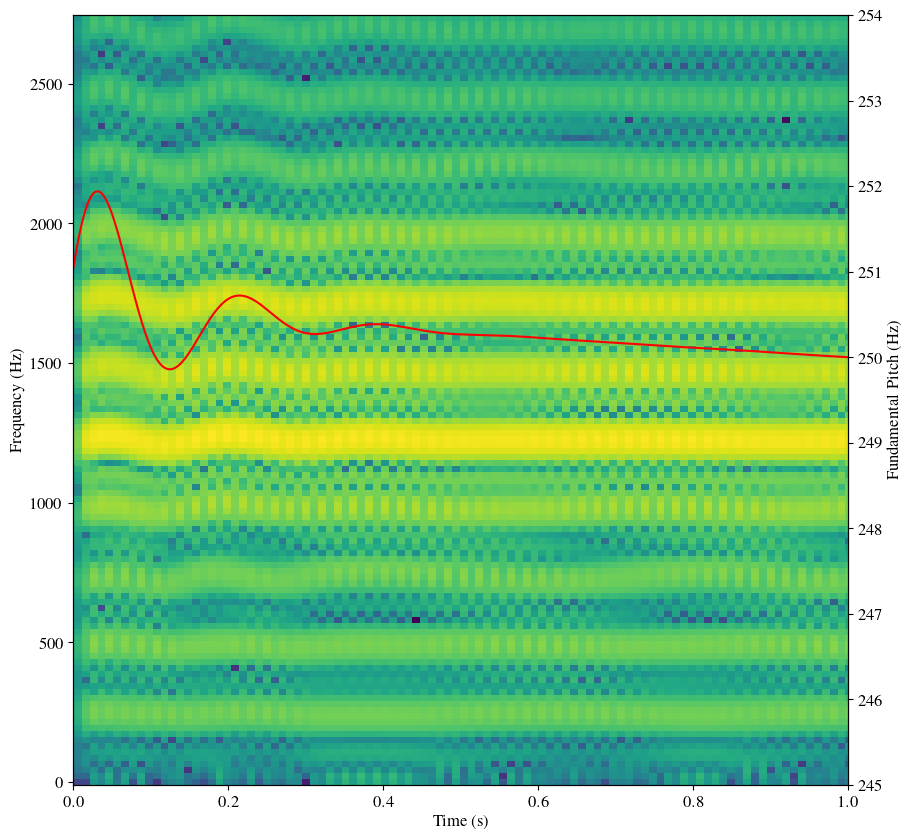

In [22]:
fs, audio_data = wavfile.read(DATA_PATH + 'vowelFromTemplate/tiltCompensation/output_a.wav')

# compute the spectogram
f, t, psd = spectrogram(audio_data, fs, nfft = N)

# Plot the resulting spectrogram
plt.figure(figsize=(10, 10))
plt.pcolormesh(t, f[:128], 10*np.log10(psd[:128, :]))
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

c = contour[int(0.035*FS):]
t = np.linspace(0, 1.0, len(c))
plt.twinx()
plt.ylim(245, 254)
plt.plot(t, c, color='r')
plt.xlim(0, 1.0)
plt.ylabel('Fundamental Pitch (Hz)')

Audio(audio_data, rate=fs)

In [23]:
## CLEAN UP AUDIO FILES
# add fade in and fade out to each vowel file



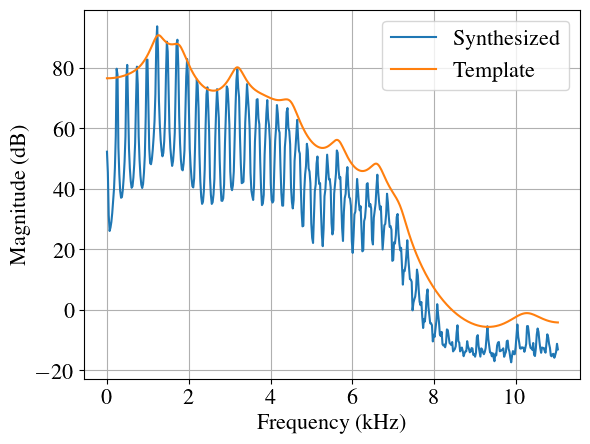

In [44]:
# PASSO 4. representamos por último o pwelch do WAV orginal e do WAV sintético

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

for vowel in vowels.keys():
    filename = 'sofia_' + vowel + '.wav'
    #fs, original = wavfile.read(SRC_PATH + "other/sofiaWav/" + filename)

    fig, ax = plt.subplots()

    #f, pxx = signal.welch(original, fs=FS, window=hsin, nfft=N)
    #plt.plot(f, 10*np.log10(2*N*pxx) + 25, label="Original (" + filename + ")")

    # load the synthesized sound
    fs, synth = wavfile.read(DATA_PATH + 'vowelFromTemplate/tiltCompensation/output_' + vowel + '.wav')

    f, pxx = signal.welch(synth, fs=FS, window=hsin, nfft=N)
    synthPSD = 10*np.log10(2*N*pxx)
    ax.plot(f/1e3, synthPSD, label="Synthesized")

    ax.plot(np.linspace(0, FS/2, N2)/1e3, vowels[vowel]-25, label="Template")

    ax.legend()
    ax.grid(True)
    ax.set_xlabel("Frequency (kHz)")
    ax.set_ylabel("Magnitude (dB)")
    #plt.title("Original vs Synthesized /" + vowel + "/")

    break
#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter5/idealSpectrum.pdf', format='pdf', dpi = 300, bbox_inches='tight')

Audio(DATA_PATH + 'vowelFromTemplate/tiltCompensation/output_e.wav', rate=FS)

/tmp/ipykernel_7016/1168446735.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio_data = wavfile.read(in_file)
/tmp/ipykernel_7016/1168446735.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f[:64], 10*np.log10(psd[:64]))


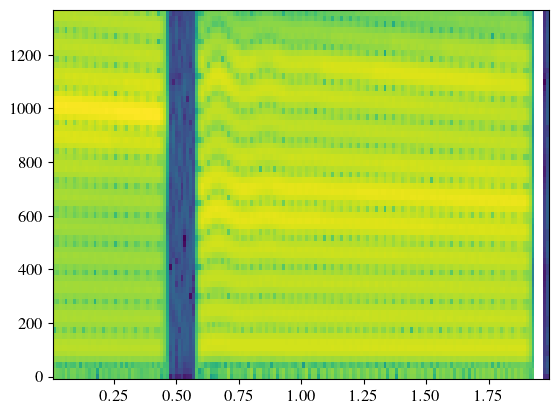

In [25]:
in_file = '/home/jorgep/Desktop/five_vowels_UV_V_envelope_models.wav'

fs, audio_data = wavfile.read(in_file)
audio_data = audio_data[1*fs:3*fs]

f, t, psd = spectrogram(audio_data, fs,nperseg=N2, noverlap=256, window='hann', nfft=N)

plt.figure()
plt.pcolormesh(t, f[:64], 10*np.log10(psd[:64]))

Audio(audio_data, rate=fs)